In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/porto-seguro-safe-driver-prediction/sample_submission.csv
/kaggle/input/porto-seguro-safe-driver-prediction/train.csv
/kaggle/input/porto-seguro-safe-driver-prediction/test.csv


# Loading packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

# Loading data

In [3]:
train = pd.read_csv('/kaggle/input/porto-seguro-safe-driver-prediction/train.csv')
test = pd.read_csv('/kaggle/input/porto-seguro-safe-driver-prediction/test.csv')

# Data at first sight

데이터 설명의 일부
- 유사한 그룹에 속하는 features는 feature name에 **tag** 지정. ind, reg, car, calc)
- feature의 접미사가 **bin**이면 binary feature, **cat**이면 categorical feature
- 위와 같은 표시가 없으면 연속적인 값을 가지거나 순서를 가지는 features
- 결측치는 **-1**로 나타냄
- target은 보험계약자에 대한 청구가 접수되었는지 여부를 나타냄

In [4]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [5]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


- binary 변수
- categorical 변수는 정수값을 가짐
- 다른 값들은 정수 또는 소수
- 결측치는 -1로 나타내짐
- target, ID

In [6]:
train.shape

(595212, 59)

59개의 변수, 595212행으로 구성되었으며, test 데이터도 변수 개수가 같은지 확인

In [7]:
# 중복된 값이 있는지 확인
train.drop_duplicates()
train.shape

(595212, 59)

중복된 행이 없음을 확인

In [8]:
test.shape

(892816, 58)

변수의 개수가 하나 작지만, 이는 target 변수이므로 상관 없음

우리가 가지고 있는 각 유형의 변수 개수 확인

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

bin 변수는 이미 이진 변수이므로 더미화할 필요가 없으며, 14개의 명목 변수는 더미화 진행


info()를 통해 데이터 타입이 정수형인지 실수형인지 볼 수 있음
데이터셋에서 null값은 보이지 않지만, 일반적으로 결측치는 -1로 대체되어 있기 때문에 null이 없는 것처럼 보임

# Metadata

데이터 관리를 용이하게 하기 위해 변수에 대한 메타 정보를 DataFrame에 저장
- 이는 분석, 시각화, 모델링 등에 필요한 특정 변수를 선택할 때 유용함

- **role**: input, ID, taget
- **level**: nominal, interval, ordinal, binary
- **keep**: Ture or False
- **dtype**: int, float, str

In [10]:
data = []
for f in train.columns:
    # role 정의
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
    
    # level 정의
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    # id를 제외한 모든 변수의 keep=True 초기화
    keep = True
    if f == 'id':
        keep = False
        
    # data type 정의
    dtype = train[f].dtype
    
    # 모든 변수의 메타데이터를 담을 Dict 생성
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [11]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


제거되지않은 모든 명목변수를 추출하는 예

In [12]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

role과 level별 변수의 수

In [13]:
pd.DataFrame({'count':meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


# Descriptive statistics

dataframe에 describe 메소드를 적용할 수 있음
- 범주형 변수나 id에 대해서는 평균, 표준편차를 계산이 의미 X

우리가 만든 meta를 통해 기술통계를 계산할 변수를 쉽게 선택할 수 있음
- 명확히 하기 위해, 데이터 유형별로 수행

**Interval variables**

In [14]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


reg
- ps_reg_03에 결측치 존재
- min ~ max 범위는 변수마다 다름
- 스케일링을 적용할 수 있으나 사용하려는 분류기에 따라 달라짐 

car
- ps_car_12, ps_car_15에 결측치 존재
- 변수마다 범위가 다르므로 스케일링 적용할 수 있음

calc
- 결측치 없음
- 최댓값이 0.9인 것을 통해 비율로 보임
- 세 개의 calc 변수가 매우 비슷한 분포를 가짐

전반적으로, 변수들의 범위가 작은 것을 볼 수 있음

이는 데이터의 익명화를 위해 log와 같은 변환이 이미 적용되었을 수 있음

**Ordinal variables**

In [15]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- 결측치는 ps_car_11에만 존재
- 변수별 범위가 다르기 때문에 스케일링을 적용시킬 수 있음

**Binary variables**

In [16]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- train data의 target 평균은 3.645%로 매우 불균형함
- 평균을 통해 대부분의 변수의 값이 0을 가지는 것을 알 수 있음

# Handlin imbalanced classes

위에서 언급했듯, target은 1보다 0값이 더 많음

이는 모델의 정확도는 높일 수 있지만, 어떠한 부가 가치를 가지지 않는다.

이 문제를 해결할 수 있는 두 가지 방법
- target=1인 레코드를 oversampling
- target=0인 레코드를 undersampling

train set이 꽤 크므로 **undersampling**을 사용함

In [17]:
desired_apriori = 0.10

# target 값별 인덱스
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# target 값별 레코드의 수
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# undersampling 비율을 계산하고 target=0 레코드의 수 확인
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate * nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# target=0인 값을 무작위로 선택
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# 나머지 인덱스로 list 재구성
idx_list = list(undersampled_idx) + list(idx_1)

# undersample한 dataframe
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


# Data Quality Checks

**결측치 확인**

결측치는 -1로 나타나있음

In [18]:
vars_with_missing = []

for f in train.columns:
    missing = train[train[f] == -1][f].count() # 결측치 개수
    if missing > 0:
        vars_with_missing.append(f) # 결측치가 존재하는 컬럼
        missing_perc = missing/train.shape[0] # 결측 비율
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missing, missing_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values


- **ps_car_03_cat**과 **ps_car_05_cat**은 결측치 비율이 매우 크므로 제거
- 결측치를 가진 다른 categorical 변수는 결측치를 -1로 남겨놓음
- **ps_reg_03(continuous)**의 결측 비율은 18% 이므로, 평균으로 대체
- **ps_car_11(ordinal)**은 5개의 결측치가 존재하므로 최빈값으로 대체
- **ps_car_12(continuous)**은 1개의 결측치 밖에 없으므로 평균값으로 대체
- **ps_car_14(continuous)**는 7%의 결측치가 존재하므로 평균값으로 대체

In [19]:
# 결측치가 많은 변수 제거
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(columns = vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop), 'keep']=False # 메타 정보 업데이트

# 결측치 대체
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

**categorical 변수의 카디널리티 확인**

카디널리티는 변수에서 고유값 수를 나타냄

이후에, 범주형 변수에서 더미 변수를 만들기 위해 고유값의 개수를 확인

이러한 변수들은 많은 더미 변수를 만들어내므로 다르게 처리해야 함

In [20]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


**ps_car_11_cat**에만 많은 고유값이 존재함

In [21]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [22]:
train_encoded, test_encoded = target_encode(train['ps_car_11_cat'],
                                           test['ps_car_11_cat'],
                                           target = train.target,
                                           min_samples_leaf = 100,
                                           smoothing = 10,
                                           noise_level = 0.01)

train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat', 'keep'] = False # 메타 정보 업데이트
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

# Exploratory Data Visualization

**Categorical variables**

명목 변수들의 target=1 비율 확인

<Figure size 640x480 with 0 Axes>

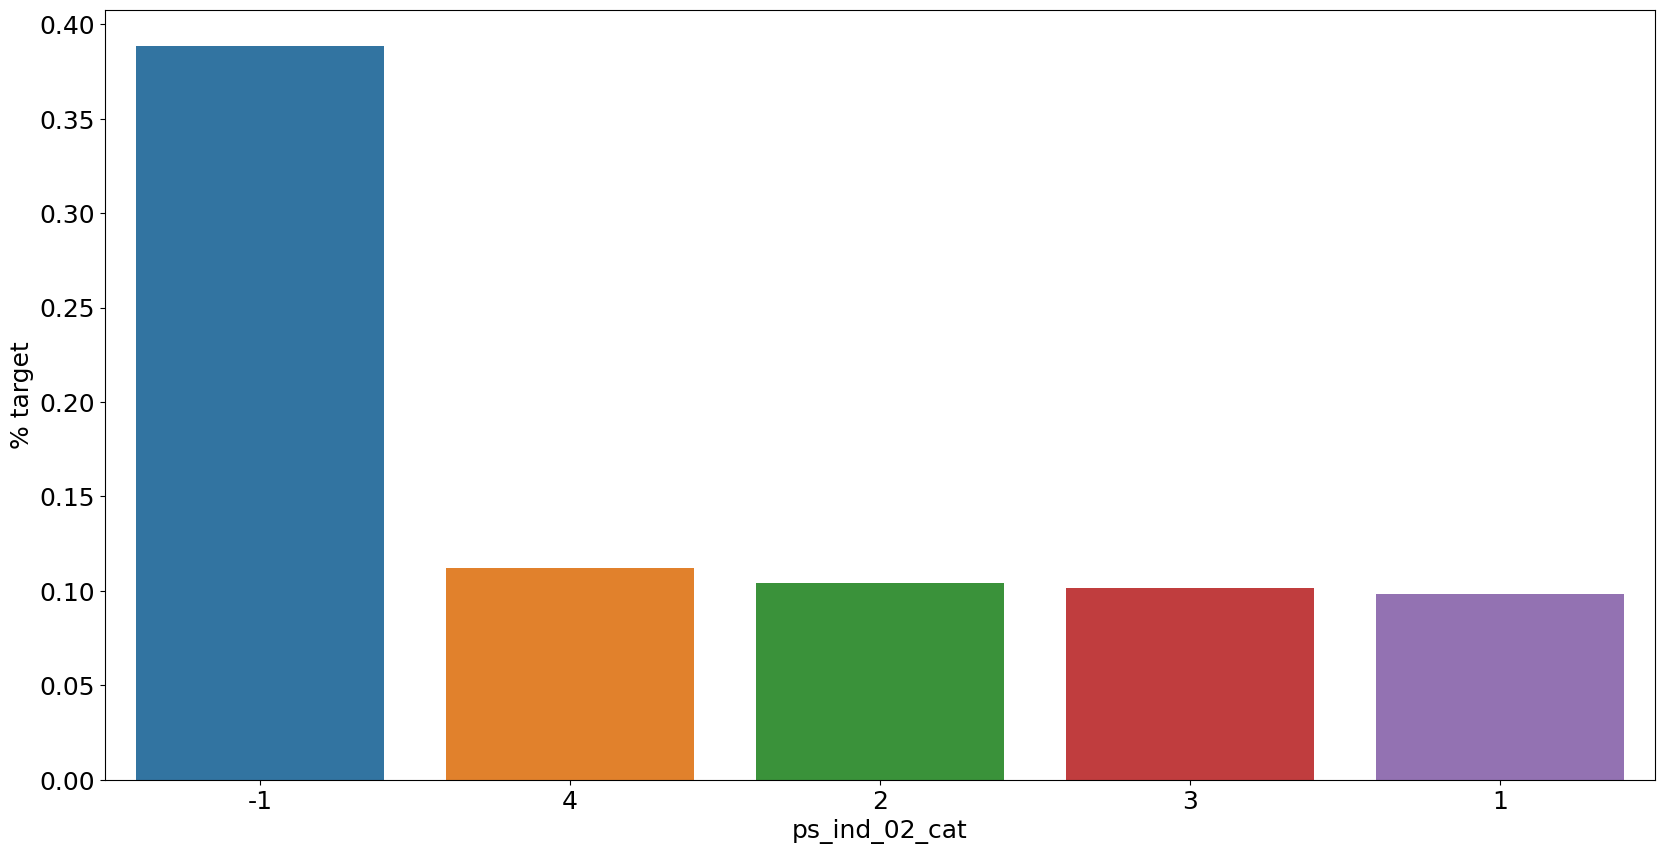

<Figure size 640x480 with 0 Axes>

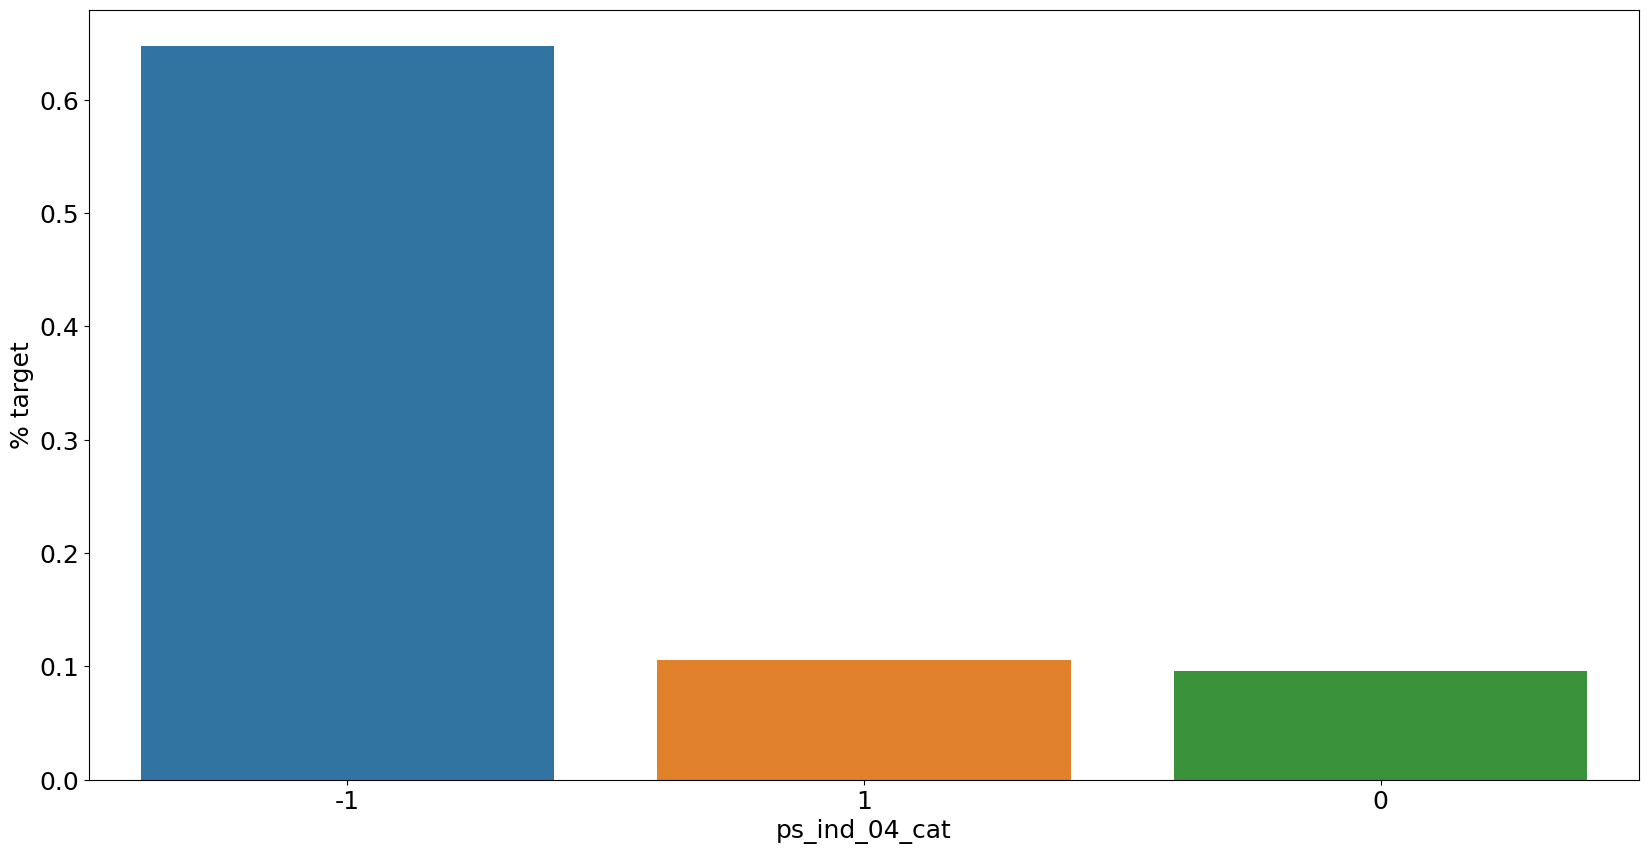

<Figure size 640x480 with 0 Axes>

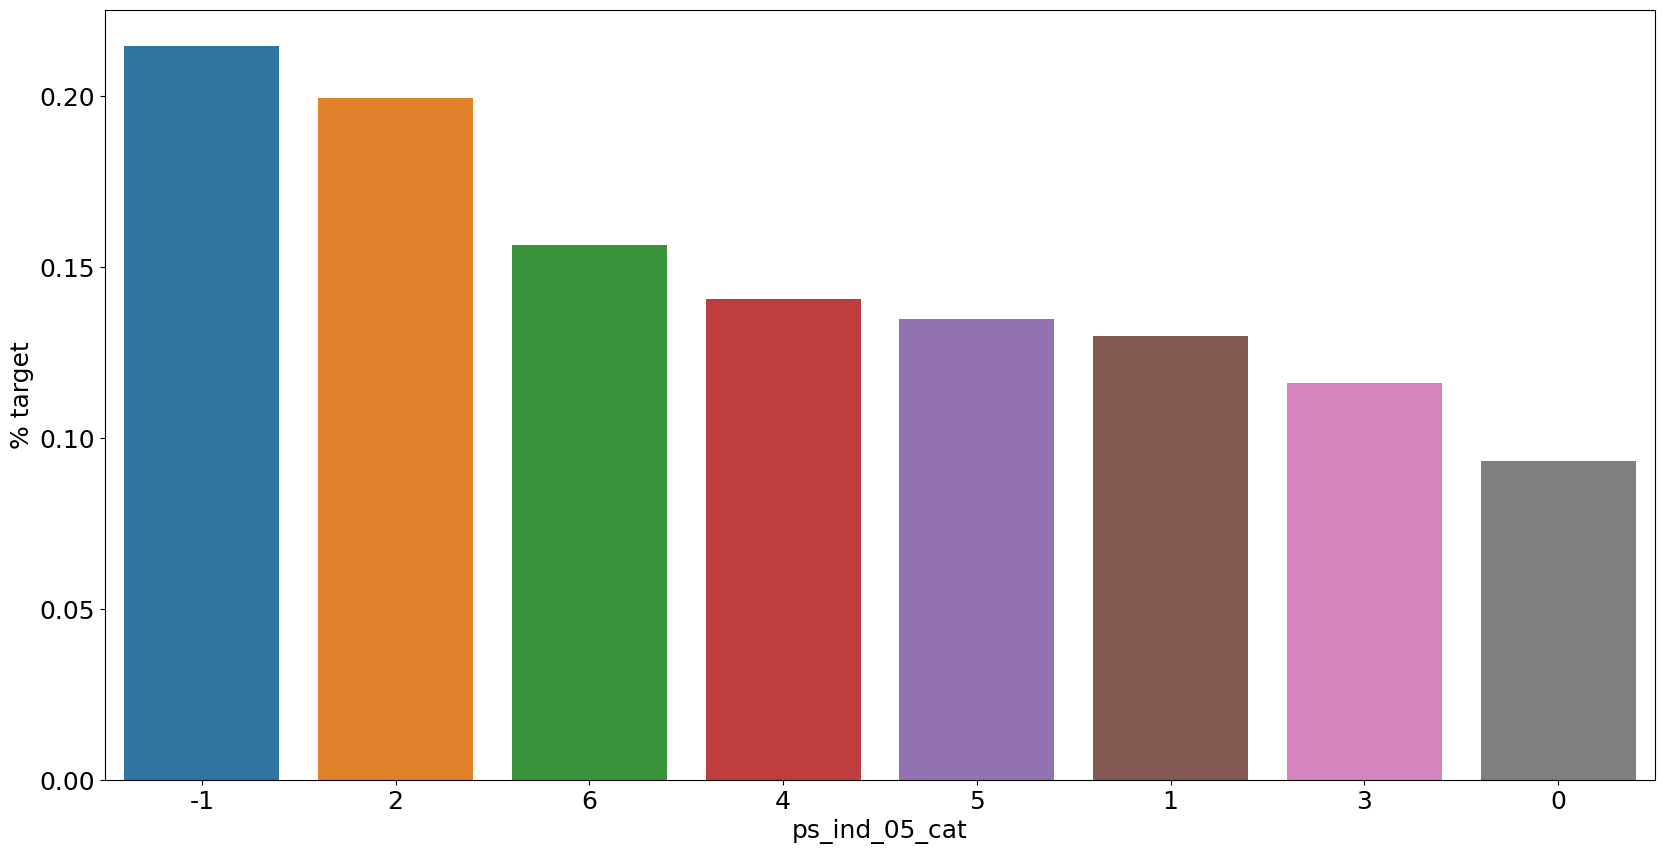

<Figure size 640x480 with 0 Axes>

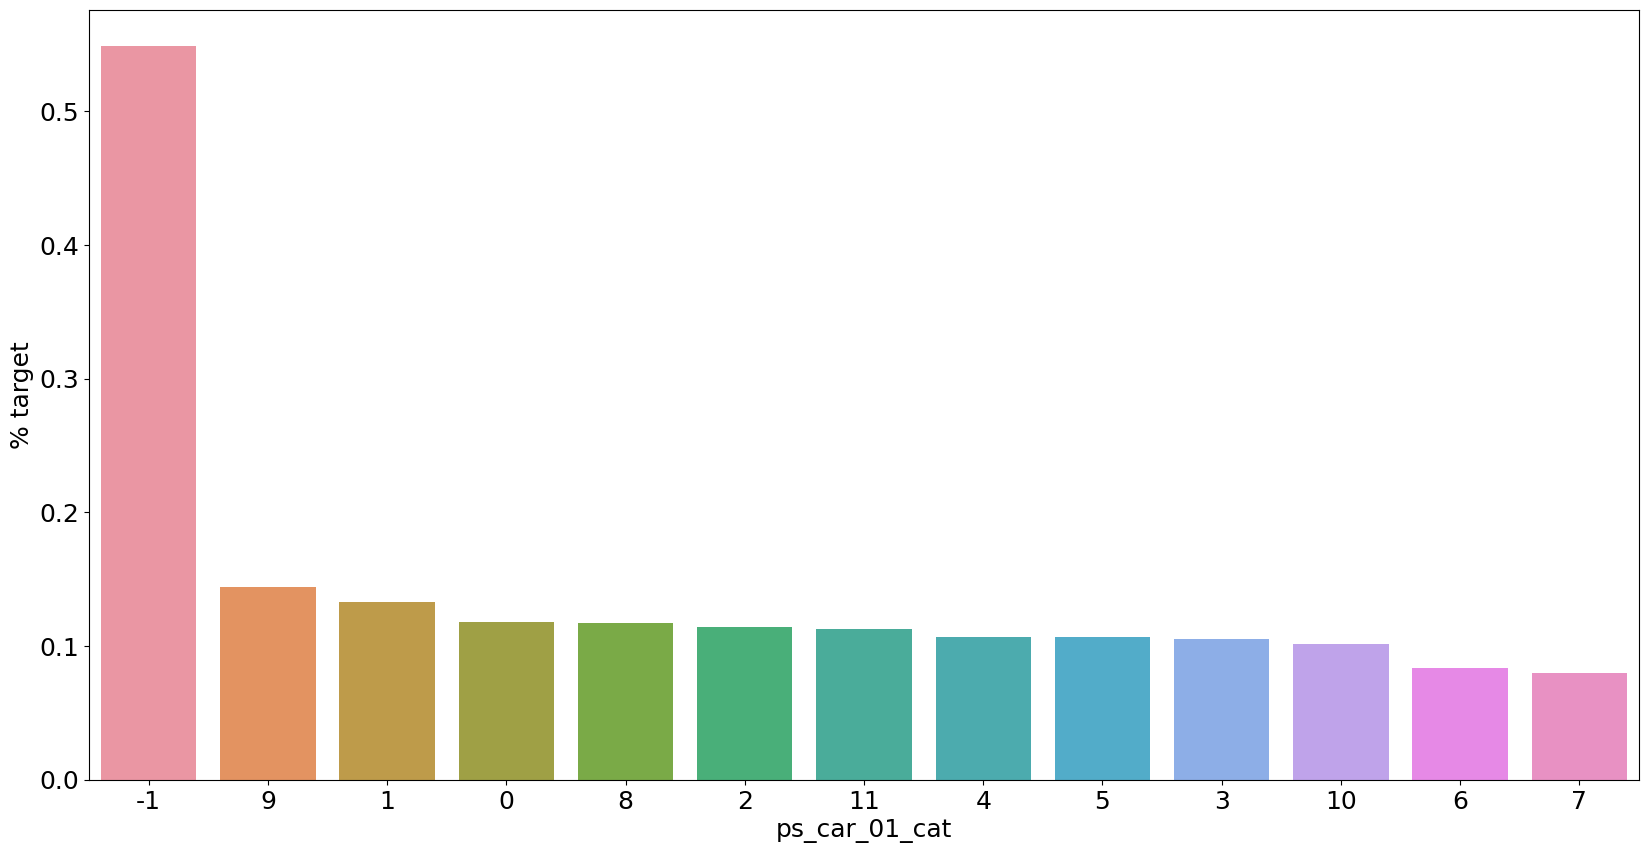

<Figure size 640x480 with 0 Axes>

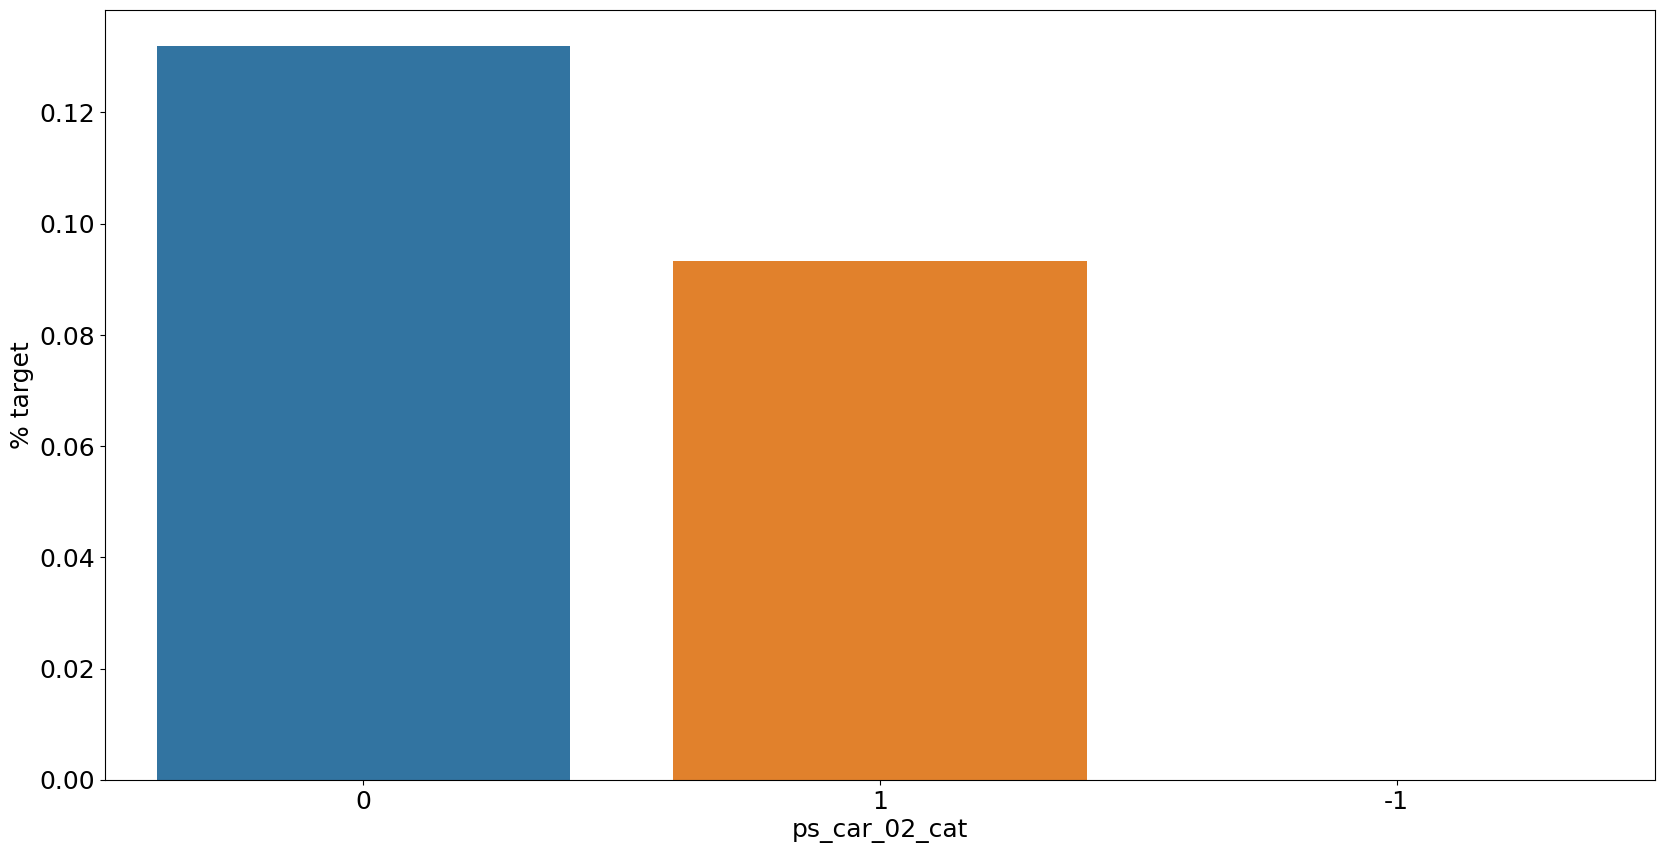

<Figure size 640x480 with 0 Axes>

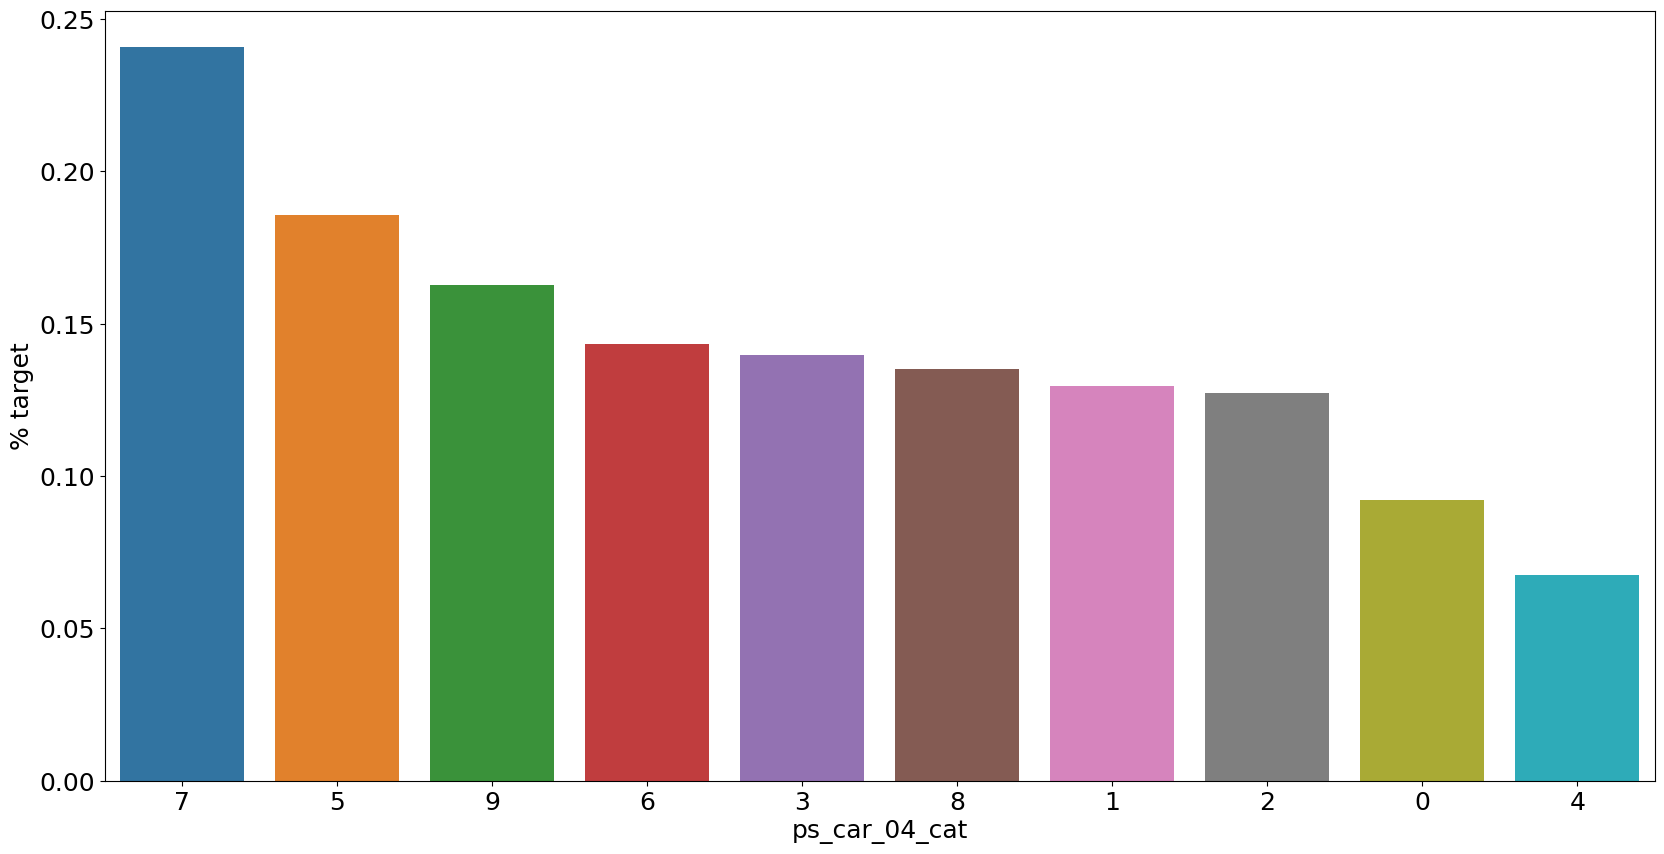

<Figure size 640x480 with 0 Axes>

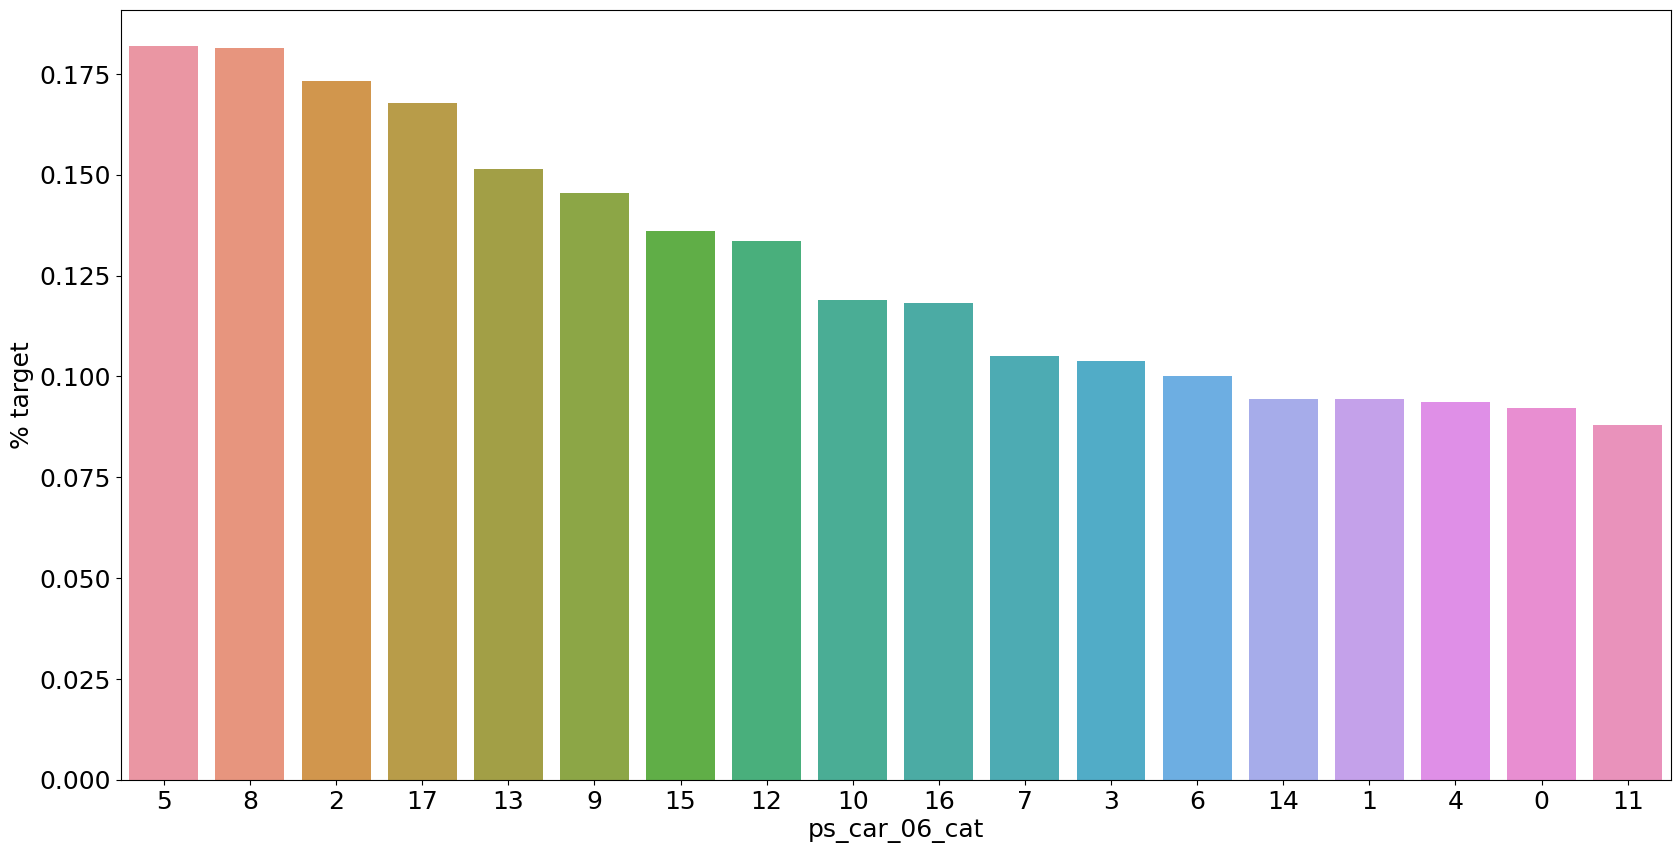

<Figure size 640x480 with 0 Axes>

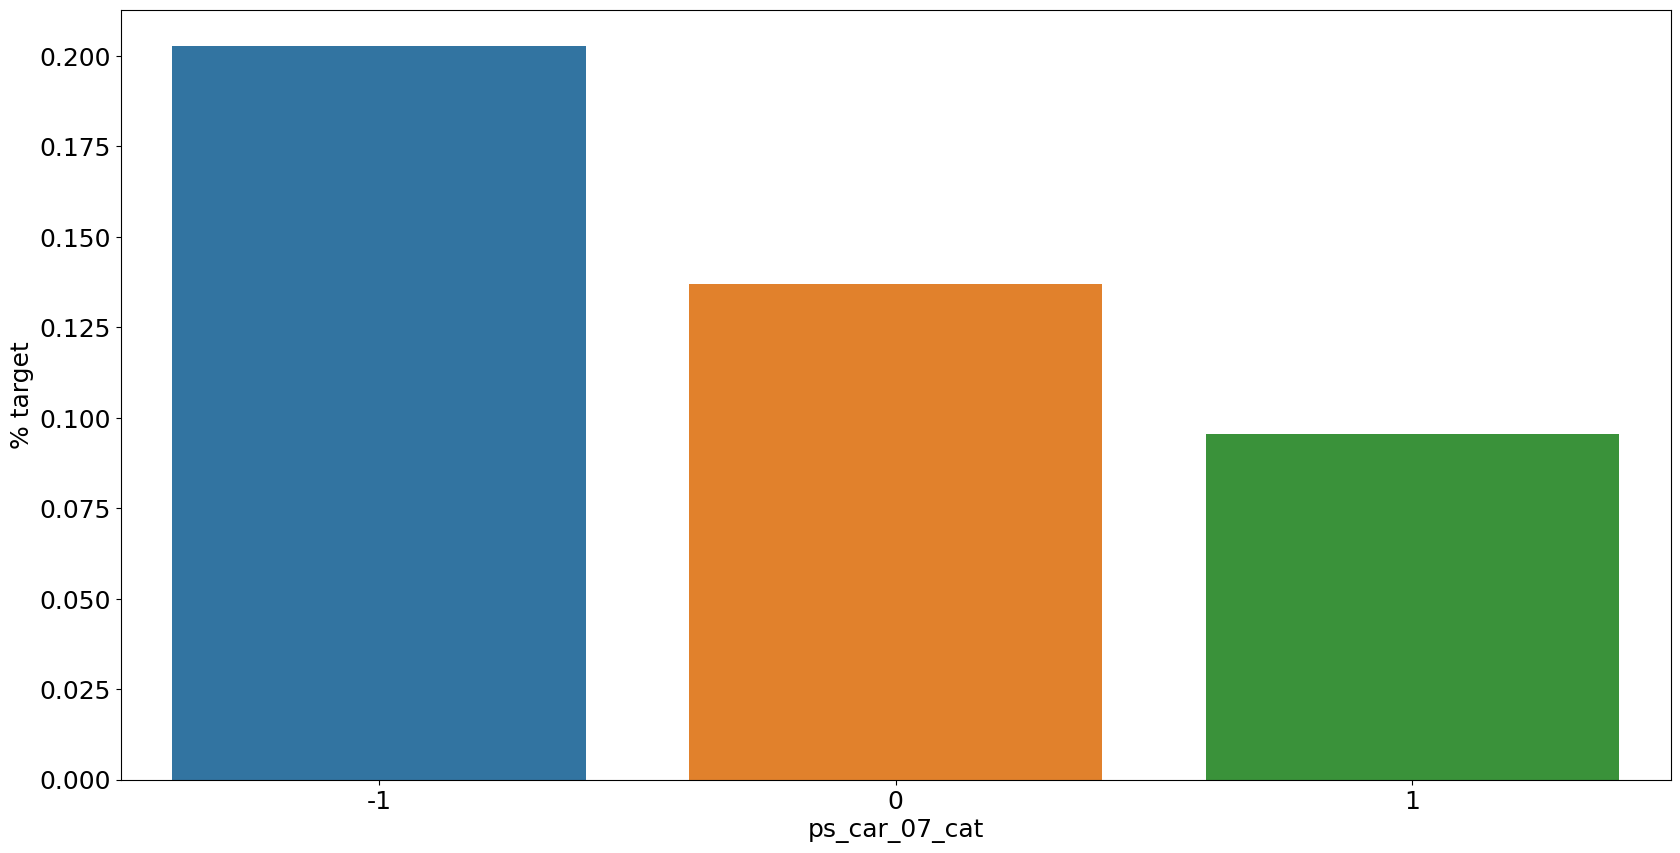

<Figure size 640x480 with 0 Axes>

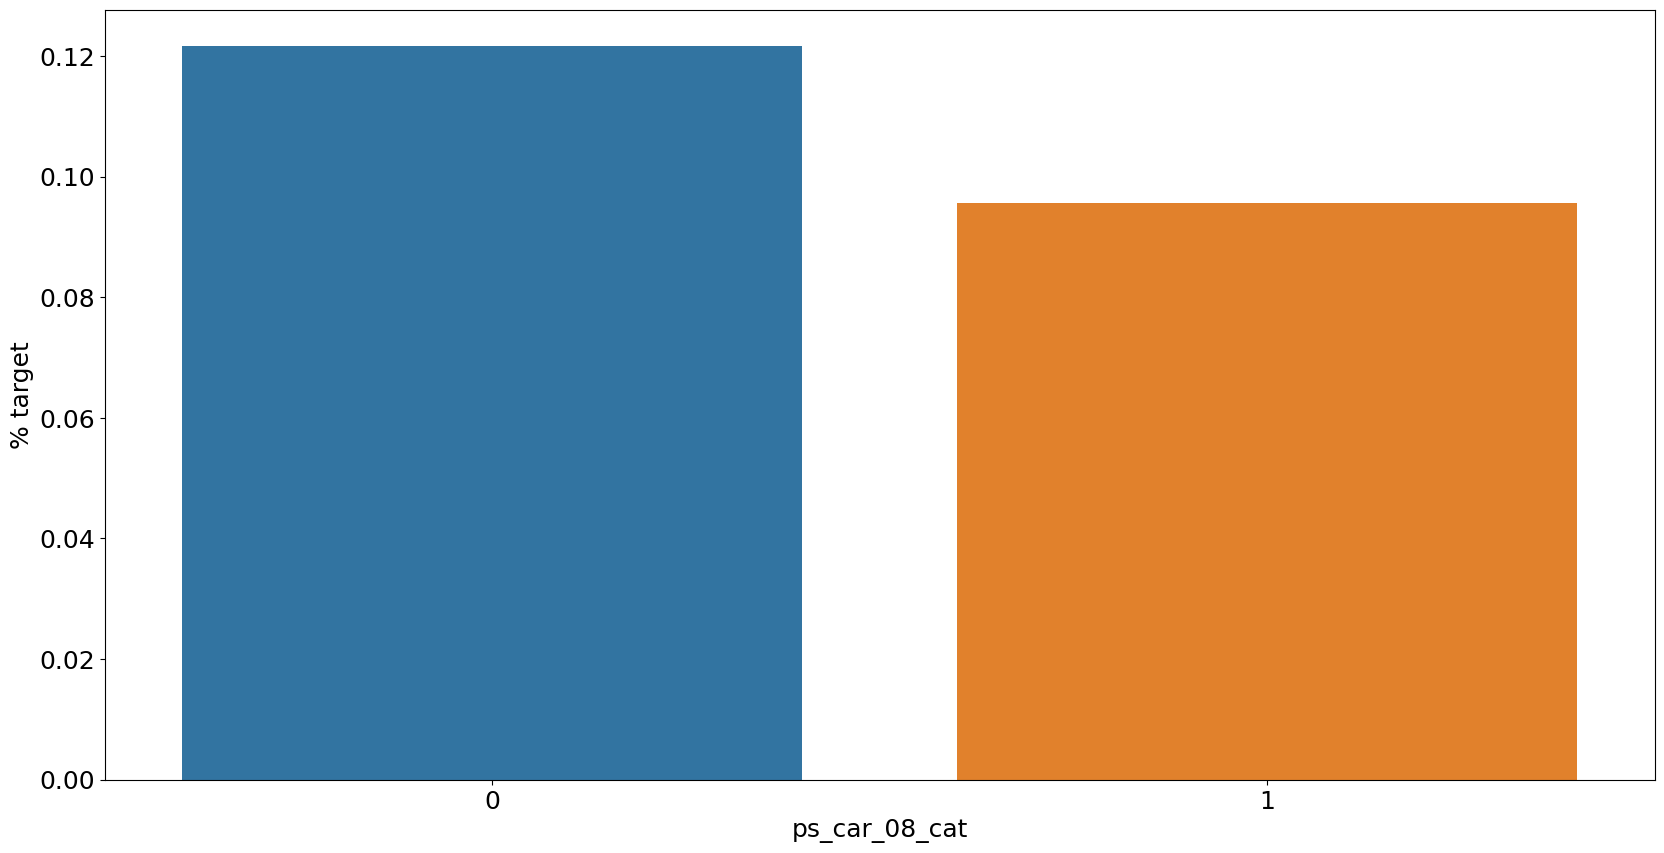

<Figure size 640x480 with 0 Axes>

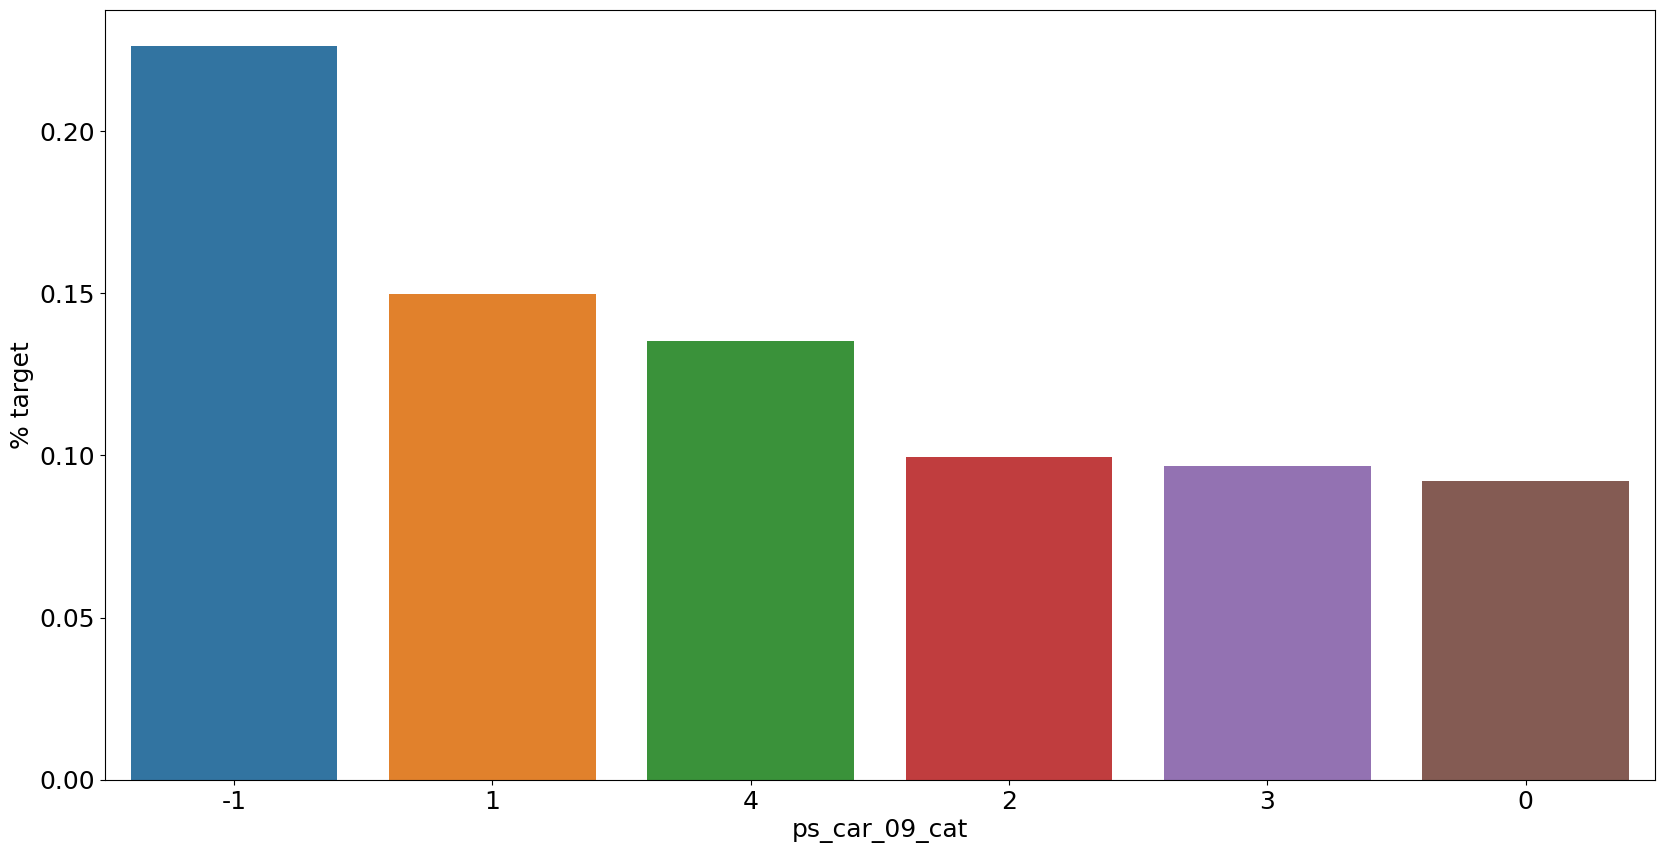

<Figure size 640x480 with 0 Axes>

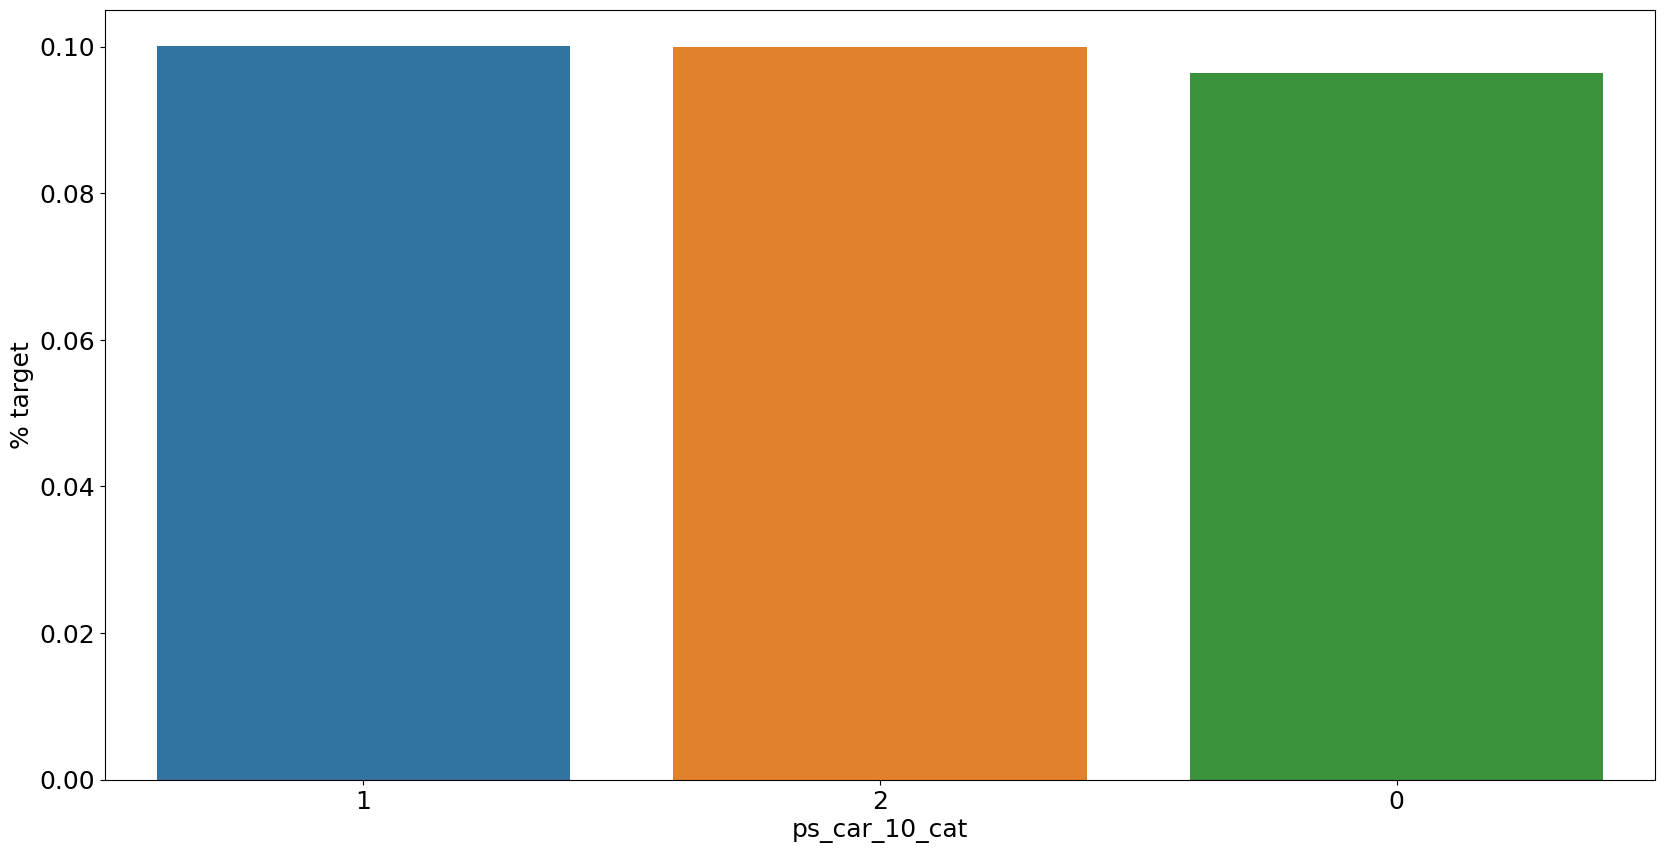

In [23]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # target=1 비율
    cat_perc = train[[f, 'target']].groupby([f], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # barplot
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show()

결측치(-1)가 존재하는 변수가 존재함을 알 수 있음
- 누락된 값을 최빈값으로 대체하는 것보다 별도의 값으로 유지하는 것이 좋음
- 결측치가 존재하는 고객은 보험을 청구할 확률이 더 높게(더 낮게) 나타남

**Interval variables**

interval 변수들 간의 상관관계 확인
- heatmap은 변수 사이의 상관관계를 시각화 하는 좋은 방법

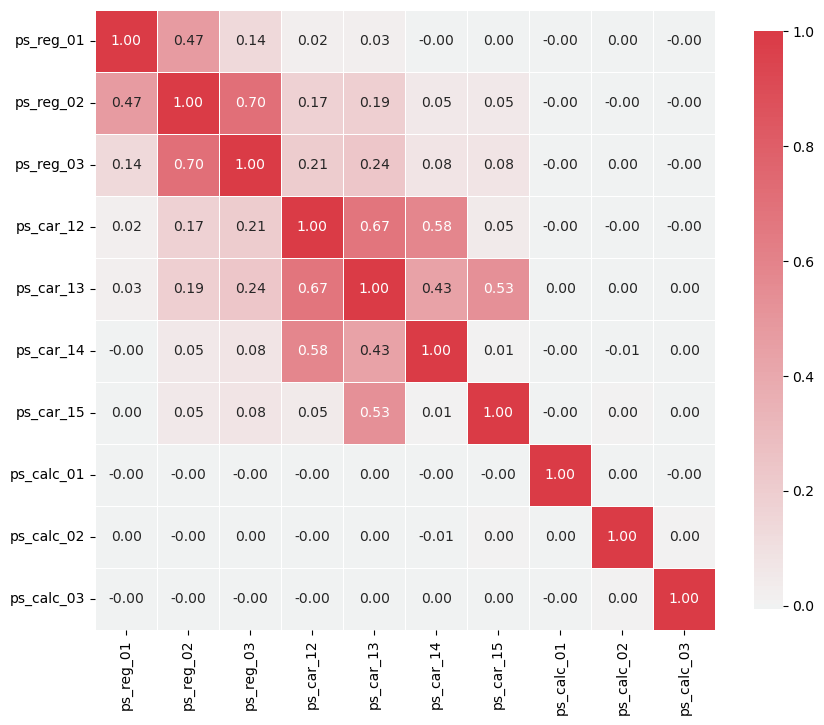

In [24]:
def corr_heatmap(v):
    correlations = train[v].corr()
    # color map 범위
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
               square=True, linewidths=.5, annot=True, cbar_kws={'shrink':.75})
    plt.show()
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

강한 상관관계
- ps_reg_02, ps_reg_03
- ps_car_12, ps_car_13
- ps_car_12, ps_car_14
- ps_car_13, ps_car_15

seaborn은 변수들 간의 (선형)관계를 편리하게 시각화 할 수 있음

pairplot을 사용해도 변수들 간의 관계를 시각화 할 수 있음

그러나 heatmap에는 제한된 수의 상관관계를 가지는 변수를 보여주므로, 높은 상관관계를 가지는 변수를 각각 살펴봄

In [25]:
# 속도를 위해 훈련 데이터 샘플을 사용
s = train.sample(frac=0.1)

**ps_reg_02와 ps_reg_03**

회귀선을 통해, 두 변수 간 선형 관계가 존재함을 알 수 있음
- target=0과 target=1의 회귀 선이 같음

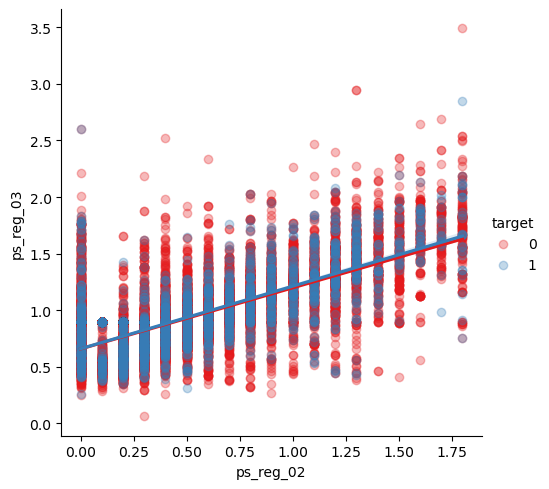

In [26]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

**ps_car_12와 ps_car_13**

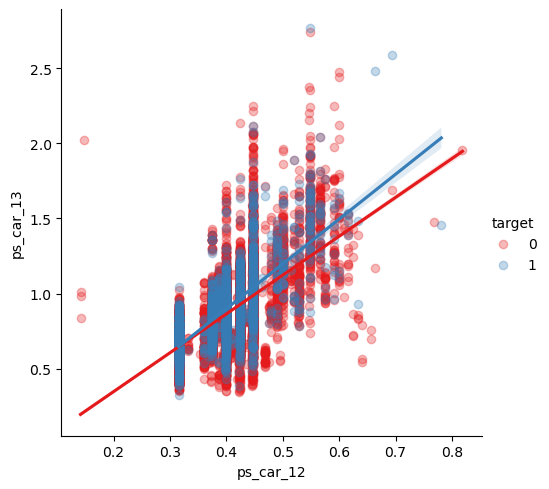

In [27]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

**ps_car_12와 ps_car_14**

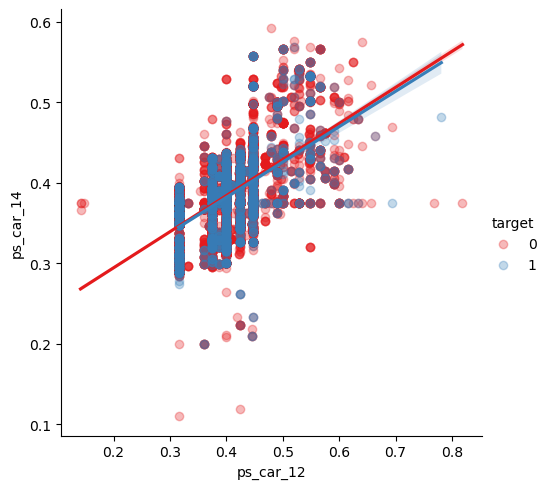

In [28]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

**ps_car_13과 ps_car_15**

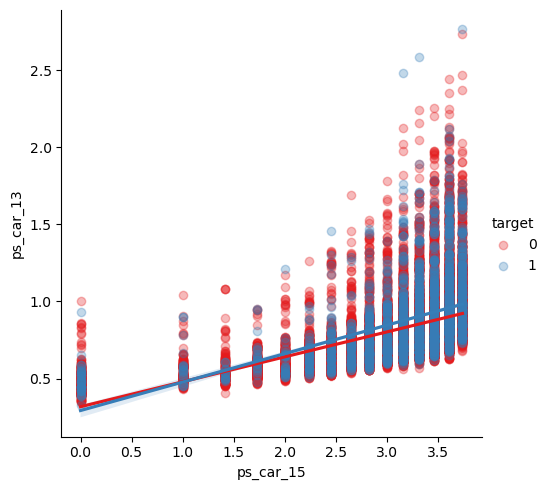

In [29]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

어떤 상관 변수를 계속해서 사용할 지 결정할 것인가
- 주성분분석(PCA)을 수행하여 차원을 줄일 수 있음
- 상관 변수의 수가 적기 때문에 heavy-lifting 사용

**Checking the correlations between ordinal variables**

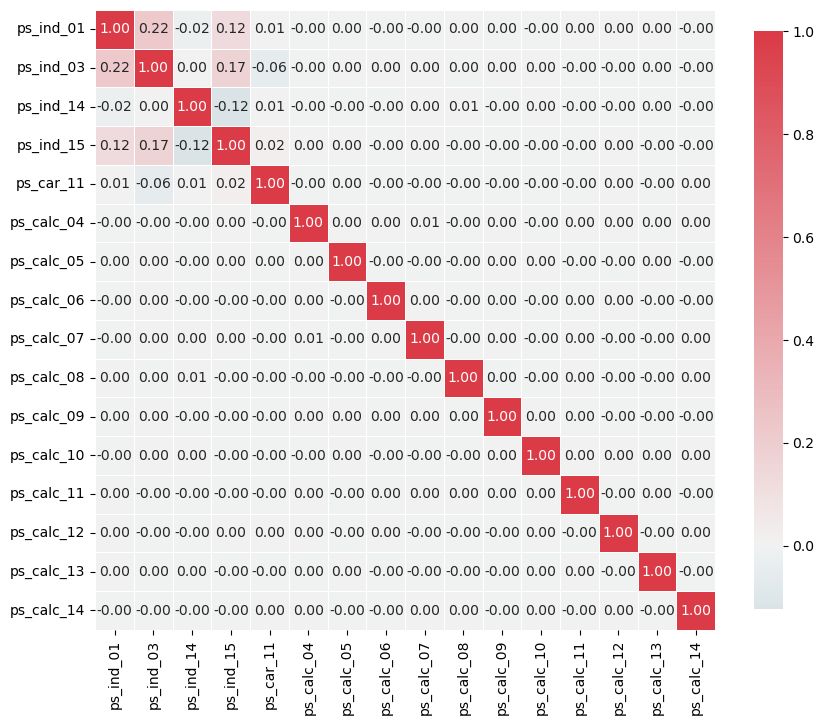

In [30]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

순서형 변수는 많은 상관관계를 가지지 않음

목표값을 기준으로 그룹화하면 어떤 분포를 가지는지 살펴봄